# Least squares regression

Philipp Schlatter, LSTM FAU, 2024

Run in Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/UA/least.ipynb

In [31]:
%%html
<style>
div.jupyter-widgets.widget-label {display: none;}
</style>

In [32]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures (widgets)
  !pip install -q ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

In [33]:
import ipympl
import matplotlib

%matplotlib widget

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from numpy.linalg import norm
import math as mt
from scipy import special
from scipy import stats
from scipy.stats import chi2,t

π = mt.pi

params = {'legend.fontsize': 10,
          'legend.loc':'best',
          'figure.figsize': (6,4),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':10,
          'ytick.labelsize':10,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

Generate some data

In [35]:
x = np.linspace(0,4,20)
xx = np.linspace(-1,5,100)
y = np.array([-1, 0.2, 0.9, 2.1])

uniform_noise = 1

y = 0.8*x+2*np.sin(x)+uniform_noise*np.random.rand(np.size(x))

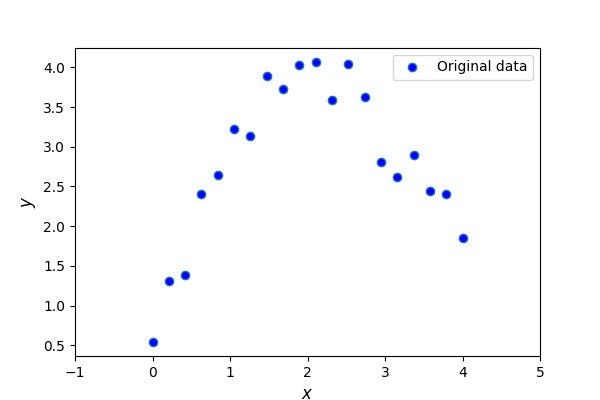

In [36]:
fig=plt.figure()
fig.canvas.header_visible = False
plt.plot(x, y, 'o', label='Original data', markersize=6,markerfacecolor='b')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.xlim(-1,5)
plt.show()

## 1. Linear least squares regression

### 1.1. Linear function

To start, let's try to fit a straight line to a set of points $\{x_i, y_i\}$, i.e. $\hat{y} = m x + b$ with the slope $m$ and the intercept $b$. The intuitive way is by computing the slope $m$ as the correlation between $x_i$ and $y_i$, and normalising by the corresponding standard deviations $\mathrm{std}(y_i)$ and $\mathrm{std}(x_i)$. The intercept can then be computed by the mean values in $x$ and $y$.

In [37]:
m1=np.corrcoef(x,y)[0,1]*np.std(y)/np.std(x)
c1 = np.mean(y)-m1*np.mean(x)
c1,m1

(2.363379743902945, 0.23432200838353792)

The same result can also be found by classical least squares. Assume that the line follows the following relation,
$$y = A p$$
with $p=[c,m]^\top$ and $A=[1^\top,x_i^\top]$. The resulting values for $c$ and $m$ can then be found by the numpy function `lstsq`:

In [38]:
A = np.vstack([np.ones(len(x)),x]).T

In [39]:
a1,a2 = np.linalg.lstsq(A, y,rcond=-1)[0]
a1,a2

(2.363379743902944, 0.23432200838353803)

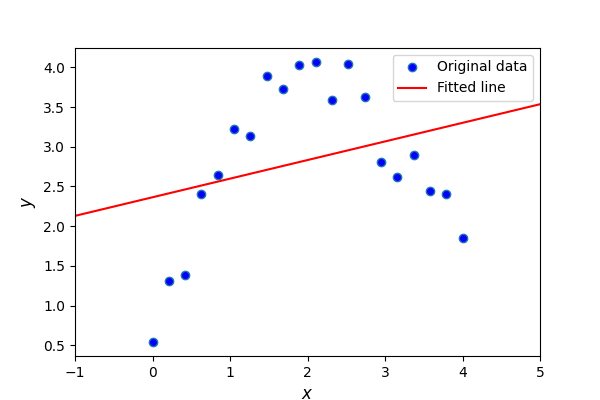

In [40]:
plt.figure()
plt.plot(x, y, 'o', label='Original data',markersize=6,markerfacecolor='b')
plt.plot(xx, a1+a2*xx, 'r', label='Fitted line')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(-1,5)
plt.legend()
plt.show()

The values for $a_j$ correspond to the minimum of the objective function
$$H=\sum_{i=1}{N} \left[ a_0 f_0(x_i) + a_1 f_1(x_i) + \ldots \right]^2$$

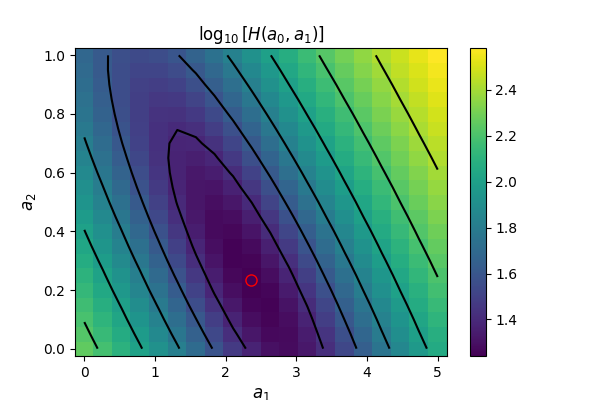

In [41]:
N_a1=21
N_a2=20
A1,A2 = np.meshgrid(np.linspace(0,5,N_a2),np.linspace(0,1,N_a1))

H=np.zeros((N_a1,N_a2))
N= y.size

for ii in range(N_a2):
    for jj in range(N_a1):
        a1N=A1[jj,ii]
        a2N=A2[jj,ii]
        for k in range(N):
            H[jj,ii] += (a1N+a2N*x[k] - y[k])**2

fig=plt.figure()
fig.canvas.header_visible = False
plt.pcolor(A1[0,:],A2[:,0],np.log10(H))
plt.colorbar()
CS=plt.contour(A1[0,:],A2[:,0],np.log10(H),colors='k')
plt.ylabel(r'$a_2$')
plt.xlabel(r'$a_1$')

plt.plot(a1,a2,'ro',ms=8)
plt.title(r'$\log_{10} [ H(a_0, a_1)] $')
plt.show()

### 1.2. Arbitrary functions for linear regression

In a similar way, even more complex linear regression can be constructed, here for instance as a combination of
$$ \hat{y} = a_1 + a_2 x + a_3 x^2 + a_4 \sin(x) \ . $$
Note that this is still linear regression as the coefficients are prefactors.

In [42]:
A = np.vstack([np.ones(len(x)),x,x**2,np.sin(x)]).T

In [43]:
a1,a2,a3,a4 = np.linalg.lstsq(A, y,rcond=-1)[0]
a1,a2,a3,a4

(0.5318627375656771,
 0.8861326452858662,
 -0.036377612423378114,
 1.9524073121454053)

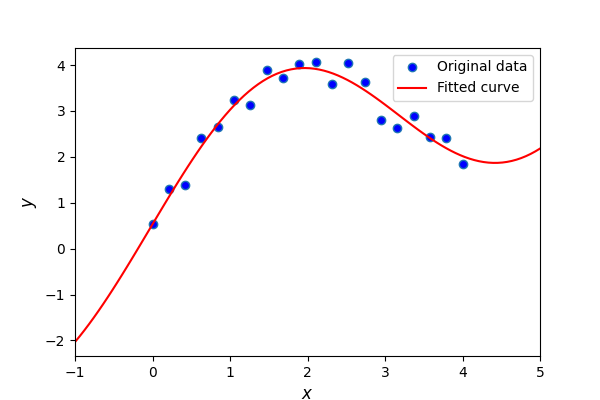

In [44]:
plt.figure()
plt.plot(x, y, 'o', label='Original data', markersize=6,markerfacecolor='b')
plt.plot(xx, a1+a2*xx+a3*xx**2+a4*np.sin(xx), 'r', label='Fitted curve')
plt.legend()
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(-1,5)
plt.show()

### 1.3. Alternative ways of computing the coefficients

The expansion coefficients $a_j$ can be computed in an equivalent way using singular value decomposition (SVD), by the pseudoinverse or simply by matrix multiplications.

In [45]:
U, S, Vh =np.linalg.svd(A,full_matrices=False)
Apinv = Vh.T@np.diag(1/S)@U.T
Apinv.dot(y)

array([ 0.53186274,  0.88613265, -0.03637761,  1.95240731])

In [46]:
Ap = np.linalg.pinv(A)     # Ap = np.linalg.inv(A.T@A)@A.T
Ap@y

array([ 0.53186274,  0.88613265, -0.03637761,  1.95240731])

In [47]:
np.linalg.inv(A.T@A)@A.T@y

array([ 0.53186274,  0.88613265, -0.03637761,  1.95240731])

### 1.4. Uncertainty analysis

The estimation of the error $\varepsilon=\hat{y}-y_i$ (i.e. its standard deviation) can be computed using `std`, subtracting two degrees of freedom (Bessel correction). For a uniform distribution, the standard deviation is $\sqrt{1/12}\approx 0.289$.

In [48]:
err = y-(a1+a2*x+a3*x**2+a4*np.sin(x))
std = np.std(err,ddof=4)
std, uniform_noise*np.sqrt(1/12)

(0.24525557225549413, 0.28867513459481287)

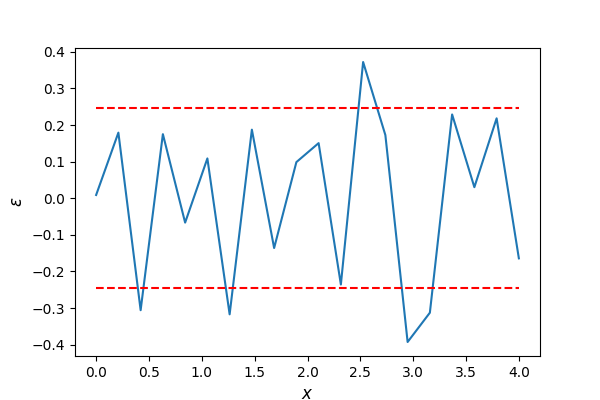

In [49]:
plt.figure()
plt.plot(x,y-(a1+a2*x+a3*x**2+a4*np.sin(x)))
plt.plot(x,x*0+std,'r--')
plt.plot(x,x*0-std,'r--')
plt.xlabel(r'$x$'); plt.ylabel(r'$\varepsilon$')
plt.show()

In [50]:
ymean = np.mean(y)
SSres = np.sum((y-(a1+a2*x+a3*x**2+a4*np.sin(x)))**2)
SStot = np.sum((y-ymean)**2)

In [51]:
R2 = 1-SSres/SStot
R2

0.9493514624509437

In [52]:
N=y.size
Rbar2 = 1-(1-R2)*(N-1)/(N-4-1)
Rbar2

0.9358451857711954

### 1.5. Monte Carlo

To figure out the sensitivity of the coefficients $a_j$, you can disturb the $x_i$ and $y_i$ using estimated uncertainties, and do a Monte Carlo run by drawing samples and re-computing the regression. This will then give you a distribution of the $a_j$. Similarly, with that distribution you can then get a distribution of the predicted $\hat{y}_i$.

Hands-on: try a MCM run

Finally, discuss overfitting and testing.